### Load Amazon review data

In [1]:
# Load Amazon review data
import os, sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.grid'] = False

from utilities import load_amazon_review_data, tokenize, lemmatize
from sklearn.feature_extraction.text import CountVectorizer

# df = load_amazon_review_data(category="electronics")
DATA_PATH = "/data/dung/PyREM"
df = pd.read_pickle(os.path.join(DATA_PATH, "./amazon-review-5core-electronics.pkl"))
df["overall"] = df["overall"].astype(int)

### Analysis

##### A few data samples

In [2]:
# df.tail(3).style.set_properties(**{'background-color': "#e6e6f2", 'color': 'black'})
df.head()

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,0528881469,Gotta have GPS!,We got this GPS for my husband who is an (OTR)...,5,AO94DHGC771SJ,amazdnu,"[0, 0]",2013-06-02,1370131200
1,0528881469,Very Disappointed,"I'm a professional OTR truck driver, and I bou...",1,AMO214LNFCEI4,Amazon Customer,"[12, 15]",2010-11-25,1290643200
2,0528881469,1st impression,"Well, what can I say. I've had this unit in m...",3,A3N7T0DY83Y4IG,C. A. Freeman,"[43, 45]",2010-09-09,1283990400
3,0528881469,"Great grafics, POOR GPS","Not going to write a long review, even thought...",2,A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","[9, 10]",2010-11-24,1290556800
4,0528881469,"Major issues, only excuses for support",I've had mine for a year and here's what we go...,1,A24EV6RXELQZ63,Wayne Smith,"[0, 0]",2011-09-29,1317254400


##### Data size

In [3]:
print('Dataset size: {:,} reviews'.format(len(df)))

Dataset size: 1,689,188 reviews


This seems to be

##### Top reviewed products and their corresponding number of reviews

In [4]:
product_review_counts = df['overall'].groupby(df['asin']).count()
product_review_counts_sorted = product_review_counts.sort_values(ascending=False)
product_review_counts.head()
print("Top 20 Reviewed Products:\n")
print(product_review_counts_sorted[:20], end='\n\n')

Top 20 Reviewed Products:

asin
B007WTAJTO    4915
B003ES5ZUU    4143
B00DR0PDNE    3798
B0019EHU8G    3435
B002WE6D44    2813
B003ELYQGG    2652
B0002L5R78    2599
B009SYZ8OC    2542
B00BGGDVOO    2104
B002V88HFE    2082
B0074BW614    2069
B000LRMS66    1960
B006GWO5WK    1917
B000QUUFRW    1890
B005FYNSPK    1884
B005HMKKH4    1866
B0041Q38NU    1812
B00622AG6S    1710
B004QK7HI8    1581
B005DKZTMG    1564
Name: overall, dtype: int64



##### Extract a product to summarize its reviews

In [5]:
# Extract the product to be summarized
product_index = 501
review_counts_product_to_summarize = product_review_counts_sorted[:product_index].tail(1)
product_to_summarize_id = review_counts_product_to_summarize.index[0]
product_to_summarize = df[df["asin"]==product_to_summarize_id]
print('Product to be summarized {} has {} reviews.'.format(product_to_summarize_id, product_to_summarize.index.shape[0]))

Product to be summarized B002YIG9AQ has 308 reviews.


##### Rating histogram of the selected product

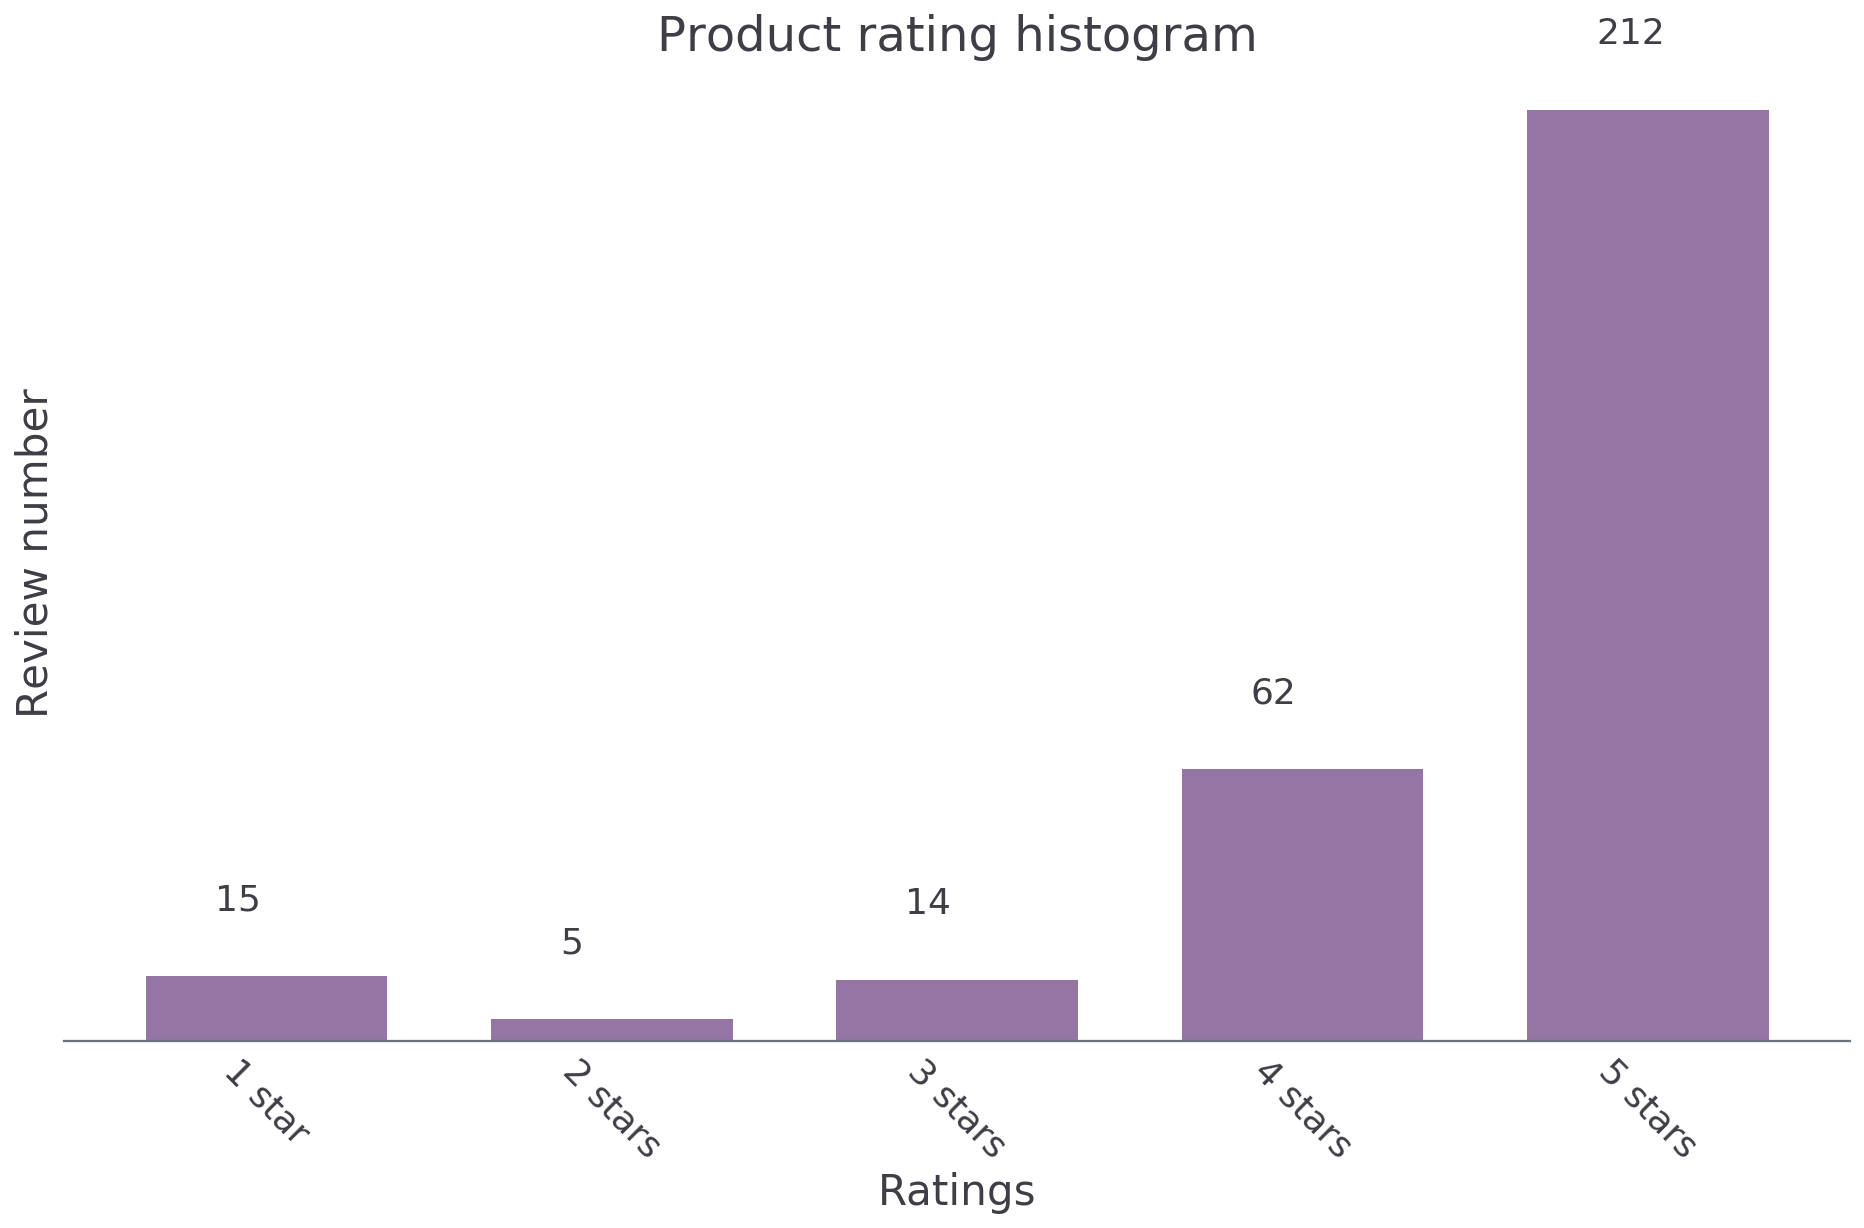

In [20]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
barWidth = 0.7

ratings = product_to_summarize['overall'].values
unique_ratings = np.unique(ratings)
rating_counts = []
for rating in unique_ratings:
    rating_count = len(ratings[ratings == rating])
    rating_counts.append(rating_count)
    ax.bar([rating], [rating_count], width = barWidth, color = (0.3,0.1,0.4,0.6), label='Alone')

ax.set_xlabel('Ratings', fontsize=21)
ax.set_ylabel('Review number', fontsize=21)
ax.set_title('Product rating histogram', fontsize=24)
plt.xticks([r+1 for r in range(len(rating_counts))], ['1 star', '2 stars', '3 stars', '4 stars', '5 stars'], rotation=-45, fontsize=18)

# Create labels
label = []
 
# Text on the top of each barplot
for i in range(len(rating_counts)):
    plt.text(x = unique_ratings[i]-0.15, y = rating_counts[i]+15, s = int(rating_counts[i]), size = 18)
plt.savefig('review_rating_hist.jpg', format='jpg', dpi=600)

It seems to be a highly rated product which have an overwhelming number of positive ratings. We expect any good summarization to reflect this information.

##### Extract review texts and vectorize them using bag-of-words

In [7]:
reviews = product_to_summarize["reviewText"]
# table = product_to_summarize[["reviewText", "overall"]].head(10)
# table = table.rename(columns = {'reviewText': 'Review Text', 'overall': 'Rating'})

# styled_table = table.style.set_properties(**{'background-color': "#e6e6f2", 'color': 'black'})
# styled_table = table.style.set_properties(**{'background-color': "#e6e6e6", 'color': 'black', 'font-size': 24, 'font-family': 'Times New Roman'})
# table.style.set_properties(**{'background-color': sns.light_palette("purple").as_hex()[2]})
# html = styled_table.render()
# import imgkit
# options = {"xvfb": "", "quality": 100, "format": "jpg"}
# imgkit.from_string(html, 'styled_table.jpg', options=options)

In [8]:
tokenized_reviews = reviews.apply(lambda x: tokenize(x))
vectorizer = CountVectorizer(min_df=5).fit(reviews)
X = vectorizer.transform(reviews)

##### Run unsupervised text summarization using Row Entropy Minimization

In [9]:
from tqdm import tqdm
import numpy.matlib
np.set_printoptions(threshold=np.inf)

from solvers import WeightedLassoADMM, REM, compute_weights
import matplotlib.gridspec as gridspec
main_color = (96/255, 170/255, 175/255)
accent_color = (222/255, 124/255, 57/255)


Y = np.asarray(X.todense())
# print ('Problem size: [%d,%d]' % (Y.shape[0],Y.shape[1]))
start_time = time.time()
alpha0 = 10
alpha = alpha0
weights = np.ones(Y.shape[0])
initial_sol = np.zeros([Y.shape[0], Y.shape[0]])
decreasing_factor = 0.95
weight_type = "Entropy"
num_inner_iters = 500
num_outer_iters = 10
    
rem = REM(data=Y, initial_sol=initial_sol, alpha=alpha, norm_type=2, weights=weights,
                printing_step=20, verbose=True, TOLERANCE=[10**-7], num_admm_iters=num_inner_iters,
                affine=True,
                PCA=True, GPU=False)
# pbar = tqdm(range(num_outer_iters))
for i_outer in range(num_outer_iters):
    if i_outer > 0:
        rem.PCA = False    
    print('\nREM iteration {} with regularization parameter alpha = {:.2f}'.format(i_outer, rem.alpha))

    # RUN REM
    coarse_representative_indices, refined_representative_indices, X = rem.rem()

    # Update parameters
    rem.initial_sol = X
    rem.weights = compute_weights(X, weight_type=weight_type)
    rem.alpha = alpha0 * (decreasing_factor**(i_outer+1))
running_time = time.time() - start_time
print('Total running time: {} [s]'.format(running_time))


REM iteration 0 with regularization parameter alpha = 10.00
	ADMM iteration 260, ||Z - C|| = 2.54532e-07, ||1 - C^T 1|| = 2.56939e-07
REM iteration 1 with regularization parameter alpha = 9.50
	ADMM iteration 480, ||Z - C|| = 1.89075e-07, ||1 - C^T 1|| = 6.44689e-08
REM iteration 2 with regularization parameter alpha = 9.03
	ADMM iteration 160, ||Z - C|| = 1.05561e-07, ||1 - C^T 1|| = 4.89331e-08
REM iteration 3 with regularization parameter alpha = 8.57
	ADMM iteration 80, ||Z - C|| = 3.00872e-07, ||1 - C^T 1|| = 3.05275e-07
REM iteration 4 with regularization parameter alpha = 8.15
	ADMM iteration 200, ||Z - C|| = 3.44544e-07, ||1 - C^T 1|| = 3.54439e-07
REM iteration 5 with regularization parameter alpha = 7.74
	ADMM iteration 140, ||Z - C|| = 4.21915e-07, ||1 - C^T 1|| = 4.36788e-07
REM iteration 6 with regularization parameter alpha = 7.35
	ADMM iteration 60, ||Z - C|| = 1.05389e-06, ||1 - C^T 1|| = 1.10926e-06
REM iteration 7 with regularization parameter alpha = 6.98
	ADMM iter

##### Display and save selected representative reviews

In [10]:
# for i in range(refined_representative_indices.shape[0]):
#     print('\n', reviews.values[refined_representative_indices[i]])
#     print('Rating: {}'.format(ratings[refined_representative_indices[i]]))
from palettable.colorbrewer.sequential import Greens_9, Purples_9
representatives = product_to_summarize.iloc[refined_representative_indices][["reviewText", "overall"]]
table = representatives
styled_table = table.style.set_properties(**{'background-color': Purples_9.colors[2], 'color': 'black', 'font-size': 24, 'font-family': 'Times New Roman'})
# styled_table = table.style.set_properties(**{'background-color': sns.light_palette("purple").as_hex()[2]})
html = styled_table.render()
import imgkit
options = {"xvfb": "", "quality": 100, "format": "jpg"}
imgkit.from_string(html, 'representative_Amazon_review.jpg', options=options)
styled_table

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,reviewText,overall
685241,"Perfect performance, easy install, everything just works. Fast ejecting tray, great transfer speeds. Everything that I needed for my new PC build.",5
685342,"these drives are reliable and cheap, burns cds and dvds fast, plug and play sata slot, its very quiet when reading cds",5
685420,"Replaced an older SATA drive, amazon always come thru. you can always find something that fits any budget. get what you want.",5
685231,"This drive is a fantastic replacement for my dead LG IDE drive. I have used many Lite-On drives over the years since they are so reliable and was very happy to come across these. It is impossible to locate IDE DVD/CD drives these days. Checked locally and no luck. I found this SATA drive on AMAZON and figured I could work with it. Checked my MB first and found an available SATA socket. Used a 24"" SATA to Right Angle SATA Serial Cable (SATA24RA1) also from AMAZON. Installation was super fast and this drive works flawlessly. Please note this is a bare bones drive (no paperwork, no software). The price on this was so good that I picked up an extra drive for future use. AMAZON shipped it very quickly and and everything was well packaged. Thank you AMAZON for the free shipping!!!",5
685334,Good optical drive. Recommended for anyone who needs a good cheap drive for a custom computer build. Bought as a part of a hackintosh desktop build.,5
685350,"Wanted to use this to ""BURN"" Videos and Home Movies from My Macbook-pro Laptop to Disc!!! As that is what this was supposed to do! But Doesn't!! So it's a paper weight!! It ""Plays"" regular Movies but does ""NOT"" Burn or copy anything!!!!! Didn't come with any software!! Very disappointed!! I even bought an enclosure that hooked up to the USB to make it easy... But it didn't get it to work any better either!!",1
685258,"When your buying a CD/DVD burner for you CPU. You basically just need it to install Windows and other software. So it doesn't make much of a difference. I've had no problems at all with it for about 4 months now. The only real downside to this CD/DVD burner is the noise. It's a good bit louder than the one on my laptop. It's not annoyingly loud, so don't get me wrong. I'm just saying it could be a little more quiet.For the price I paid for this thing, which was a little under 20$. I do recommend this CD/DVD burner. Although if you have a few more dollars to spend you could always pay 10 bucks so when your doing installs it'll be a little more quiet. But I don't think many people care that much. If you need a CD/DVD player for under 20 bucks that's high quality and high speed, and don't mind a little noise during installations, this is it. It's normally quiet, it's only loud when heavy reading or writing is done.",4


##### The selected representative reviews not only represent key features of the product but also offer physical context, e.g., written by real users, which is lacked in word-counting based techniques such as PCA.
For example, it's not clear from the wordcloud below which feature of the drives is fast. This, however, can be infered clearly from the representative reviews, e.g., the drives burn cds and dvds fast.

Word-counting techniques lack of context


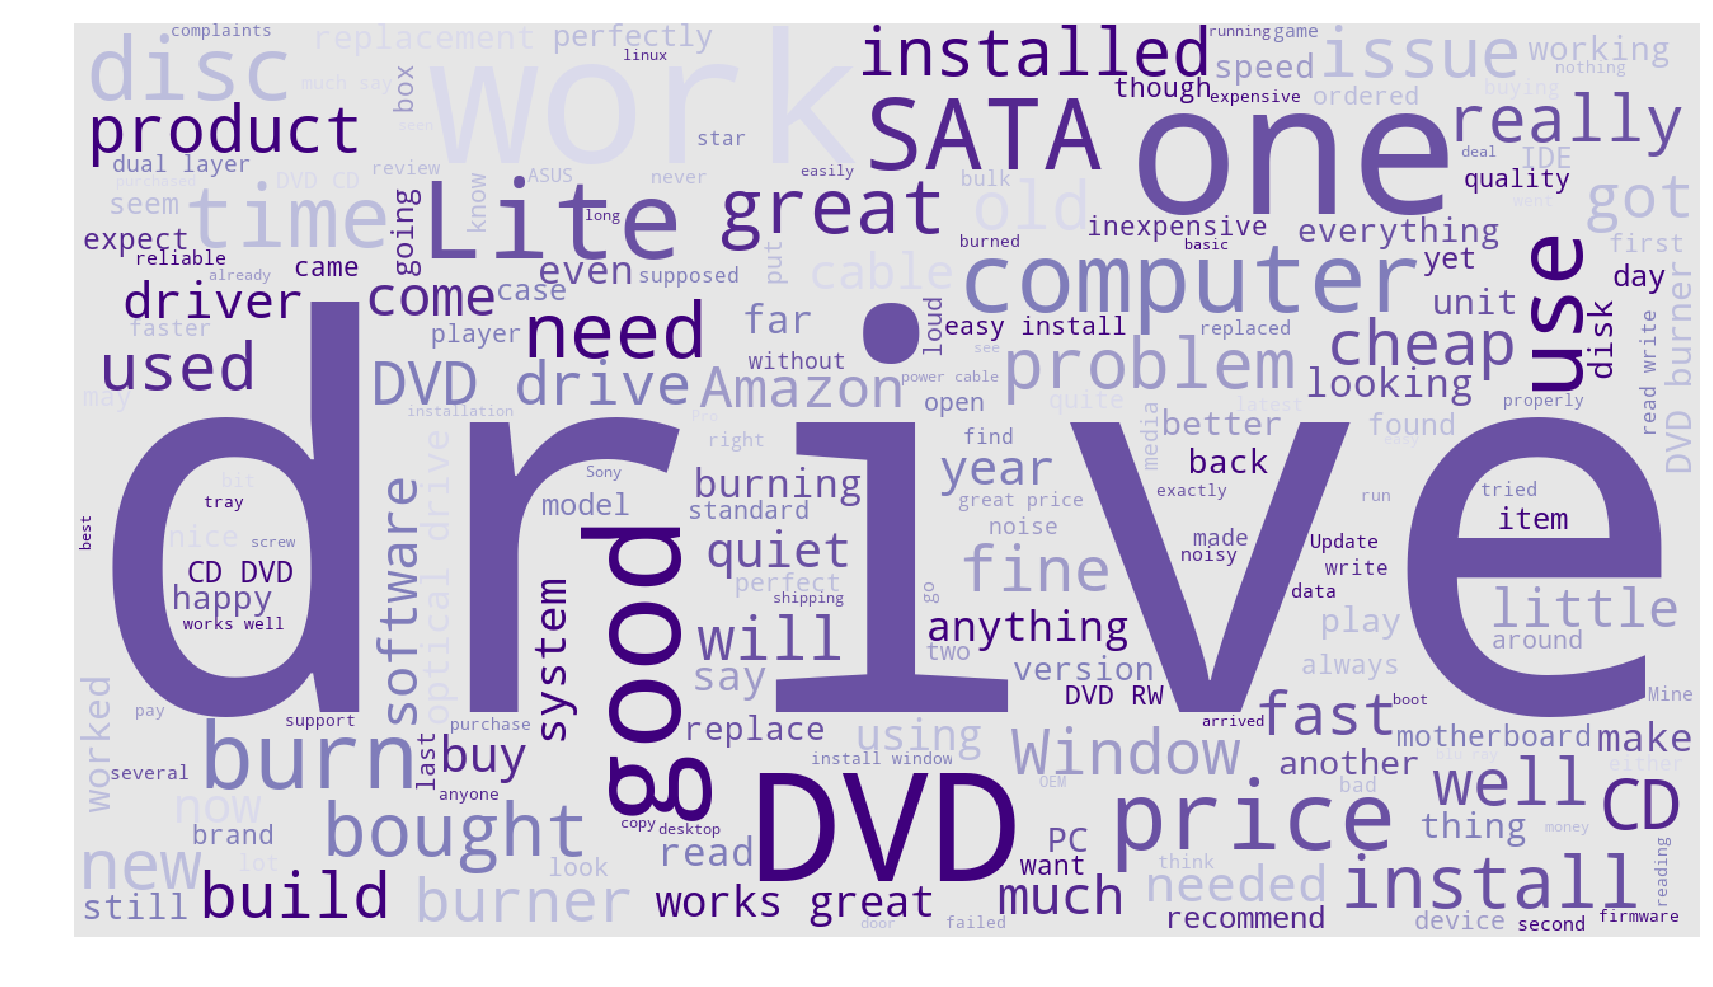

In [25]:
from palettable.colorbrewer.sequential import Purples_9
import random
import wordcloud
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Purples_9.colors[random.randint(2,8)])

cloud = wordcloud.WordCloud(background_color='#e6e6e6', max_font_size=2400, 
                                relative_scaling=1, width=1280, height=720).generate(' '.join(reviews))
cloud.recolor(color_func=color_func, random_state=3)
fig = plt.figure(figsize=(12, 7))
plt.axis('off')
print("Word-counting techniques lack of context")
plt.imshow(cloud);
plt.tight_layout()
# plt.title("Word-counting techniques lack of context")
plt.savefig('review_rating_wordcloud.jpg', format='jpg', dpi=300)